In [81]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [82]:
# Load your dataset
clean_data = pd.read_csv("/Users/sa20/Desktop/Housing-Prices/Data/processed/clean_data.csv")

clean_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,706,856,856,...,0,1,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,978,1262,1262,...,0,1,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,486,920,920,...,0,1,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,216,756,961,...,1,0,1,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,655,1145,1145,...,0,1,0,0,1,0,0,0,1,0


In [83]:
X = clean_data.drop('SalePrice', axis=1)  # Features (excluding SalePrice)
y = clean_data['SalePrice']  # Target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

# Fill NaNs in categorical columns with 'N/A'
X_train[cat_cols] = X_train[cat_cols].fillna("N/A")

# one-hot encoding to categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)

In [84]:
# Set up Linear Regression model
lr_model = LinearRegression()

# Train Linear Regression model
lr_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_encoded)

# Calculate metrics for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print results for Linear Regression
print(f"Linear Regression - Mean Squared Error: {mse_lr:.2f}")
print(f"Linear Regression - R-squared Score: {r2_lr:.2f}")


Linear Regression - Mean Squared Error: 1073270691.66
Linear Regression - R-squared Score: 0.86


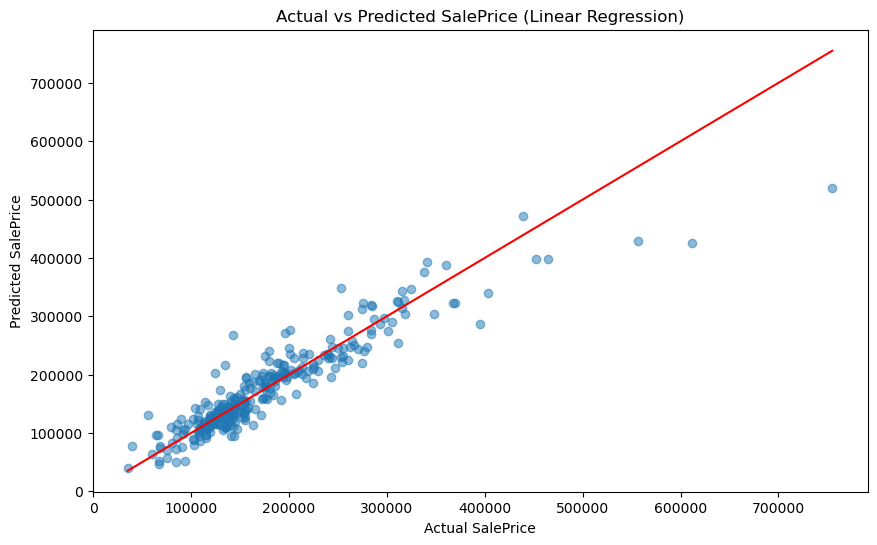

In [85]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red') 
plt.title("Actual vs Predicted SalePrice (Linear Regression)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

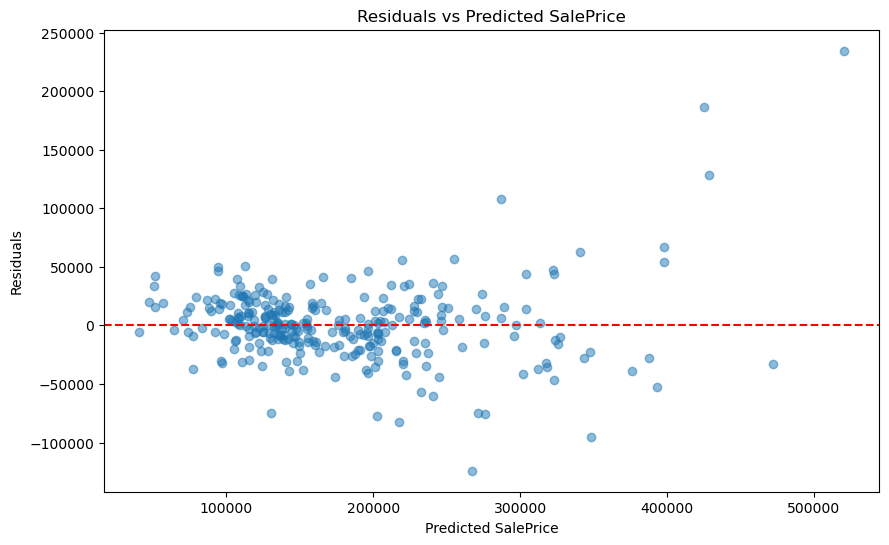

In [86]:
# Plot residuals
plt.figure(figsize=(10,6))
residuals = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted SalePrice")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.show()


### Linear Regression 
- The linear regression model achieved an R² score of 0.86 and a Mean Squared Error of 1.07 billion, indicating it explains a significant portion of the variation in sale prices.

- The actual vs. predicted plot shows most predictions align well with actual values, especially in the lower price range. Points near the red line indicate accurate predictions, while those above or below suggest under- or overestimation.

- The residual plot displays residuals fairly evenly around zero, supporting that the model's assumptions are mostly met and the fit is reasonable overall.


# Random Forest with Random Search

In [87]:
# Train + evaluate the Random Forest 
rf_mod = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mod.fit(X_train_encoded, y_train)
y_pred_rf = rf_mod.predict(X_test_encoded)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest - R-squared Score: {r2_rf:.2f}")


Random Forest - Mean Squared Error: 770387948.83
Random Forest - R-squared Score: 0.90


In [98]:
# Random Forest model
rf_mod = RandomForestRegressor(random_state=42)

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),         
    'max_depth': randint(10, 50),                
    'min_samples_split': randint(2, 10),       
    'min_samples_leaf': randint(1, 10),        
    'max_features': ['sqrt', 'log2'],    
    'bootstrap': [True, False]                  
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_mod,
    param_distributions=param_dist,
    n_iter=100,                     
    cv=5,       
    scoring='neg_mean_squared_error',   
    verbose=1,                     
    random_state=42,
    n_jobs=-1                       
)

# Fit model w/  RandomizedSearchCV
random_search.fit(X_train_encoded, y_train)

# Get the best model after hyperparameter tuning
rf_final_mod = random_search.best_estimator_

# Print best parameters 
print(f"Best Parameters: {random_search.best_params_}")

# Predict test set w/ best model
y_pred_rf_refined = rf_final_mod.predict(X_test_encoded)

# Evaluate 
mse_rf_refined = mean_squared_error(y_test, y_pred_rf_refined)
r2_rf_refined = r2_score(y_test, y_pred_rf_refined)

print(f"Random Forest (Refined) - Mean Squared Error: {mse_rf_refined:.2f}")
print(f"Random Forest (Refined) - R-squared Score: {r2_rf_refined:.2f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'bootstrap': False, 'max_depth': 44, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 875}
Random Forest (Refined) - Mean Squared Error: 885958200.95
Random Forest (Refined) - R-squared Score: 0.88


### Random Forest  

- Base Model  
  - R² Score: 0.90  
  - Mean Squared Error: 770,387,948.83

- Refined Model (w/ Hyperparameter Tuning)  
  - R² Score: 0.88  
  - Mean Squared Error: 885,958,200.95
  
Surprisingly, the base Random Forest model slightly outperformed the refined version in both R² and MSE. This suggests that hyperparameter tuning did not improve performance and may have led to overfitting


# Test Data

In [89]:
# Load test data
test_data = pd.read_csv('../data/raw/test.csv')

test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [90]:
# Identify test categorical columns
test_cat_cols = test_data.select_dtypes(include=["object", "category"]).columns

# Fill missing values in categorical columns
test_data[test_cat_cols] = test_data[test_cat_cols].fillna("N/A")

# One-hot encoding to match training data
test_data_encoded = pd.get_dummies(test_data, columns=test_cat_cols, drop_first=True)

# Align test data columns with training data
test_data_encoded = test_data_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Verify 
print(f"Test Data Encoded Columns: {test_data_encoded.columns}")

Test Data Encoded Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       ...
       'GarageType_Detchd', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'PavedDrive_P', 'PavedDrive_Y', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=182)


In [92]:
# For Consistency, drop these features (These columns were dropped in train csv)
test_drop_feats = ['MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 
                  'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'PoolArea', 'MiscVal', 
                  'Street', 'GarageQual', 'SaleType', 'GarageCond', 'Heating', 'Electrical', 
                  'Utilities', 'Id', 'PoolQC', 'MiscFeature', 'Fence', 'Alley', 'BsmtUnfSF', 
                  'KitchenAbvGr', 'LandSlope', 'Condition2', 'RoofMatl']

test_data = test_data.drop(columns=test_drop_feats, axis=1)

In [93]:
test_data.shape

(1459, 54)

In [95]:
pred_prices = rf_final_mod.predict(test_data_encoded)

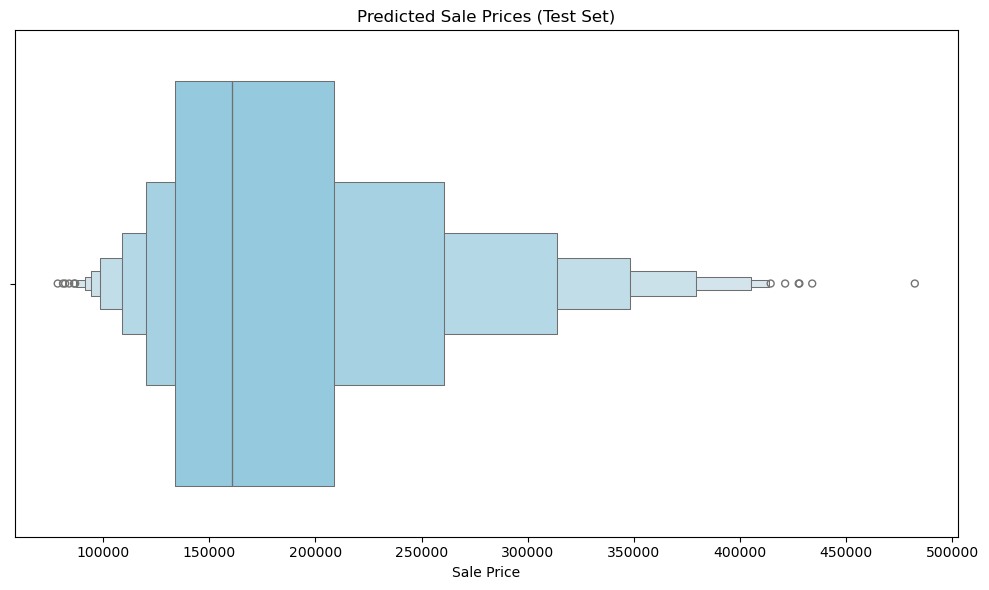

Predicted SalePrice Summary:
Min: $78,699.46
Max: $482,279.32
Mean: $180,639.55
Median: $160,748.46


In [97]:
# Plot distribution of predicted sale prices
plt.figure(figsize=(10, 6))
sns.boxenplot(x=pred_prices, color="skyblue")
plt.title("Predicted Sale Prices (Test Set)")
plt.xlabel("Sale Price")
plt.tight_layout()
plt.show()

# Display summary of predicted sale prices
print("Predicted SalePrice Summary:")
print(f"Min: ${np.min(pred_prices):,.2f}")
print(f"Max: ${np.max(pred_prices):,.2f}")
print(f"Mean: ${np.mean(pred_prices):,.2f}")
print(f"Median: ${np.median(pred_prices):,.2f}")


### Final Thoughts

##### The predicted sale prices falls within a realistic range, with most values centered around $160k–$180k, which is within my expectations 

##### Due to time constraints, additional modeling techniques such as Gradient Boosting or XGBoost, as well as more extensive hyperparameter tuning using Grid Search, were not explored but could be valuable directions for future work.
